# A gentle introduction to neurolib
> neurolib is a Python framework for easy whole-brain neural mass modeling. This post will give you background information on the science behind whole-brain simulations and help you to set up your own numerical experiments.

- sticky_rank: 1
- comments: true
- author: Caglar Cakan
- categories: [neurolib, neuroscience, tutorial]
- permalink: /neurolib-intro/
- image: images/icon_neurolib-intro.png
- license: Creative Commons

<p align="center">
  <img src="../images/neurolib-intro/icon_fh.png" width="650">
</p>

# What is neurolib?

In its essence, `neurolib` is a computational framework for simulating coupled neural mass models written in Python. It helps you to easily load structural brain scan data to construct brain networks where each node is a neural mass representing a single brain area. This network model can be used to simulate whole-brain dynamics. Finally, `neurolib` allows you to simulate BOLD activity from the underlying neural activity to be able to compare simulations to fMRI brain scan data. You can checkout `neurolib` on our [GitHub page](https://github.com/neurolib-dev/neurolib) and find a lot of [examples](https://github.com/neurolib-dev/neurolib/tree/master/examples) there, including more advanced features like parameter exploration and evolutionary optimization.

We have built `neurolib` because like for many computational neuroscientists, working with neural models is daily business. However, no open-source framework was available to help us implement our own models, run large-scale simulations and handle huge amounts of simulated data efficiently. As it happens so often in research, we ended up writing our own software for our own special case. This is why we decided to join our forces and models to create `neurolib`, a library that solves these common issues and more.

Other software projects that we're familiar with like [TheVirtualBrain](https://www.thevirtualbrain.org/) offer 
a lot of functionality with a useful UI. In `neurolib`, our goal is to create a hackable framework for coders and focus on the simulation and optimization machinery. We are not planning to add many “utility functions” like plotting data or more than just basic signal processing. In our experience, every researcher has their own workflow and we don’t want to make others rely on our implementations, when they’re usually more than fine using their own processing pipeline with everything that Python has to offer, including `matplotlib`, `numpy`, `pandas`, and `scipy`.

In this sense, `neurolib` is primarily a modern research tool and our main goal is to provide an accessible research framework. However, it is built with people in mind who are new to the field and just want to get going. We have made it as easy as possible to setup a simulation or to implement your own model and run your experiments.

We are using `neurolib` in our daily research as much as we're also working on the framework itself. In the future, we expect `neurolib` to help researchers gain better theoretical insights into their neural models, produce more useful results, and enable them to run and manage large, hierarchical, multi-model simulations. 

You're warmly invited to join our development efforts on our [GitHub page](https://github.com/neurolib-dev/neurolib), report a bug if you find issues, submit a PR with your favorite model that you want to see implemented or just [get in touch with us](mailto:caglorithm@gmail.com).

## A computational neuroscience primer

Let's start at the beginning. Computational neuroscience is the scientific field in which mathematical tools and theories are used to investigate brain function. One of these tools is network science and the study of [dynamical systems theory](https://en.wikipedia.org/wiki/Dynamical_systems_theory). Across all relevant scales for studying brain function, scientists have created mathematical models for simulating neuronal systems ranging from highly complex single neuron models which simulate individual chemical processes in the cell up to theories of large networks of neurons that disregard most of the complicated details in order to gain insights into the large-scale behavior of neural systems. 

Neural mass models are such mathematical models that help to simulate and understand the behavior of a large number of coupled neurons. Typically, these models make use of the statistical insight that the collective, macroscopic behavior of a large network of randomly connected neurons can be described without having to know the exact dynamics of every individual neuron at every time step. This is much like a statistical physicist would treat a gas where for example the temperature of the gas is an expression of the *mean* velocity of the gas particles, not the individual velocity of each particle.

<p align="center">
  <img src="../images/neurolib-intro/tractography.gif">
</p>
<p align="center" style="font-size:10px;">A DTI scan of a human brain with long-range axonal fibers. <a href="https://www.youtube.com/watch?v=GbnRuRi1B-Q">Animation source</a></p>

### Towards simulating brains

Now that we have an idea about what neural masses are, what are they useful for and how is this related to `neurolib`? One of the applications of neural mass models in computational neuroscience is in whole-brain modeling, where a coarse-grained simulation of the activity of a large network of brain areas is achieved by combining simulations of neural masses with structural connectivity scans (often referred to as the [connectome](https://en.wikipedia.org/wiki/Connectome), an example is shown in the animation above) of the human brain which captures large axonal connections that connect distant brain areas. These models offer an *in silico* approach (through computational modeling) to investigate the large-scale dynamics of the *in vivo* brain, such as the appearance and the properties of brain oscillations or the effects of electrical stimulation of certain brain areas.

`neurolib` allows you to build, simulate, and optimize your own state-of-the-art whole-brain models. To simulate the neural activity of each brain area, the main implementation provides an advanced neural mass mean-field model of spiking adaptive exponential integrate-and-fire neurons (AdEx) called `aln`. Each brain area is represented by two populations of excitatory and inhibitory neurons. An extensive analysis and validation of the `aln` model can be found in our paper [1].

[1] Cakan et al. (2020). Biophysically grounded mean-field models of neural populations under electrical stimulation. PLOS Computational Biology ([ArXiv](https://arxiv.org/abs/1906.00676)).

The figure below shows a schematic of how a brain network is constructed:

<p align="center">
  <img src="../images/neurolib-intro/pipeline.png" width="700">
</p>

On the left side of the figure, you can see structural brain scan data with the axonal fiber tractography (**Connectome**) and a parcellation scheme (**AAL2 atlas**) that divides the brain into distinct volumes. Below, you can see the **Structural connectivity** matrix, which captures the coupling strength between each area and is derived from the number of reconstructed axonal fibers from one brain area to another, and the **Delay matrix**, which captures the signal transmission delay between brain areas and is derived from the length of the fibers. On the right side, you can see a schematic of the `aln` neural mass model, representing a single **brain area** with excitatory neurons (orange population, E) and inhibitory neurons (blue population, I) and connections within and between the populations. Combining the structural brain data with the neural model is how we construct a **whole-brain model**.

## The neural mass model

In this notebook we will learn about the basics of `neurolib`. First, we will create a neural mass model of exponential integrate-and-fire neurons called the `aln` model, which represents a single brain area. We will learn how to create a `Model`, set some parameters and run a simulation. We will also see how we can easily access the output of each simulation. Later, we will create a bunch of neural mass models and couple them in a brain graph to simulate a whole-brain model.

### aln - the adaptive linear-nonlinear cascade model

The adaptive linear-nonlinear (`aln`) cascade model is a low-dimensional population model of spiking neural networks. Mathematically, it is a dynamical system of non-linear ordinary differential equations (ODEs). The dynamical variables of the system simulated in the `aln` model describe the average firing rate and other **macroscopic variables** of a randomly connected, delay-coupled network of excitatory and inhibitory **adaptive exponential integrate-and-fire neurons (AdEx)** with non-linear synaptic currents. 

Ultimately, the model is a result of various steps of model reduction starting from the Fokker-Planck equation of the AdEx neuron subject to white noise input with different mean $\mu$ and variance $\sigma$. The resulting steady-state firing rates $r$ and the linear response function of the neural population are then stored in a lookup table. When we finally simulate the system, these precomputed quantities serve as the linear filter and the nonlinear firing rate transfer function $r = \Phi(\mu, \sigma)$ in the adaptive linear-nonlinear cascade model. 

# Using neurolib

Let's get going after all this reading. `neurolib` makes it easy to set of your simulation. Below, we demonstrate how you set up a model and interact with its parameters. We will first explore a single node which represents a brain area and get comfortable with the way things work and later set up a whole-brain simulation and simulate fMRI activity.

In [1]:
#hide
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np
import scipy

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [2]:
#hide
#plt.style.use('light')

## Simulating a single node

To create a single node, we  instantiate the model without any arguments. 

In [3]:
# Let's import the aln model
from neurolib.models.aln import ALNModel

# Create the model
aln = ALNModel()

# Each model comes with a set of default parameters which are are a dictionary. 
# Let's change the parameter that controls the duration of a simulation to 10s.
aln.params['duration'] = 10.0 * 1000  

# For convenience, we could also use:
aln.params.duration = 10.0 * 1000

# In the aln model an Ornstein-Uhlenbeck process is simulated in parallel
# as the source of input noise fluctuations. Here we can set the variance
# of the process. 
# For more info: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process 
# Let's add some noise.
aln.params['sigma_ou'] = 0.1

# Finally, we run the model
aln.run()

### Accessing the outputs

Accessing the outputs is straight-forward. Every model's outputs
are stored in the `model.outputs` attribute. According to the specific
name of each of the model's outputs, they can also be accessed as a 
key of the Model object, i.e. `aln['rates_exc']`.

Let's have a look what the outputs of the `aln` model are called:

In [4]:
aln.outputs.keys()

dict_keys(['t', 'rates_exc', 'rates_inh'])

As you can see here, the model produces several outputs after executing `aln.run()`. The first entry `t` is an array of the simulation time in milliseconds:

In [5]:
aln['t']

array([1.0000e-01, 2.0000e-01, 3.0000e-01, ..., 9.9998e+03, 9.9999e+03,
       1.0000e+04])

Let's have a look, what the excitatory firing rate output `rates_exc` of the model looks like. If you're lazy, you can also access most of the key-valued objects in `neurolib` using a `dot.separated` syntax:

In [6]:
aln.rates_exc.shape

(1, 100000)

The entries of `aln.rates_exc` are the excitatory population's firing rate in time. Every model's default output, in this case `rates_exc`, can also be accessed by calling the *default* `output` attribute:

In [7]:
aln.output

array([[26.15770656, 24.06801404, 22.22713507, ...,  1.82543728,
         1.78704101,  1.75078031]])

Plotting the output against the simulated time `aln.t`, we get:

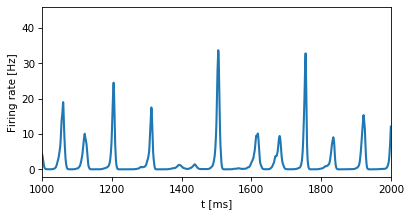

In [8]:
#hide_input
plt.figure(figsize=(6, 3), dpi=75)
plt.plot(aln['t'], aln['rates_exc'].T, lw=2)
plt.xlabel("t [ms]")
plt.ylabel("Firing rate [Hz]")
plt.xlim(1000, 2000);

Outputs are also available as an `xarray.DataArray`:

In [9]:
xr = aln.xr()
print(xr.dims)

('output', 'space', 'time')


### Exploring the state space using bifurcation diagrams

To understand the model better, we should figure out what it does if we change certain model parameters. We have already seen that adding some noise can create these nice irregular oscillations. 

One way of characterizing the effects of parameters on a dynamical system is to compute **bifurcation diagrams**. Bifurcations are sudden and often dramatic changes in a system's behavior due to a small smooth change of some parameter (the bifurcation parameter). Usually, a bifurcation results in a rapid change of a system's state such as a transition to a oscillation. In the `aln` model, as well as in most neural models with excitatory and inhibitory units, the most prominent oscillation is due to the interaction of both populations, often known as an E-I oscillation

One of the most important parameters of the `aln` model is the **external input currents to each subpopulation**. The parameter that controls the inputs to the excitatory population is called `mue_ext_mean`, which is a terrible way of saying "mean input current to the excitatory subpopulation".

Let's check the current value of this parameter:

In [10]:
aln.params["mue_ext_mean"]

0.4

Again, we could've also used the syntax `aln.params.mue_ext_mean` as well.

We want to know how our model is behaving under changes of this parameter so it might a good idea to do a quick parameter exploration. For this, we scan through a range of possible values of `mue_ext_mean`, simulate the model for a bit and record the minimum and the maximum value of the firing rate of the excitatory population `rates_exc`. We remember all these values and draw a bifurcation diagram in the end.

In [11]:
# initialize the model
aln = ALNModel()
aln.params['duration'] = 2.0*1000

# lists that will conatin the results
max_outputs = []
min_outputs = []
# these are the different input values that we want to scan
inputs = np.linspace(0, 2, 50)

# cycle through all input values
for mue in inputs:
    # Note: this has to be a vector since it is input for all nodes
    # (but we have only one node in this example)
    aln.params['mue_ext_mean'] = mue
    aln.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_outputs.append(np.max(aln.output[0, -int(1000/aln.params['dt']):]))
    min_outputs.append(np.min(aln.output[0, -int(1000/aln.params['dt']):]))

Plotting `max_outputs` and `max_inputs` against the the `inputs` gives us the bifurcation diagram of the `aln` model in the `mue_ext_mean`-direction of the parameter space:

Text(0, 0.5, 'Min / max firing rate [Hz]')

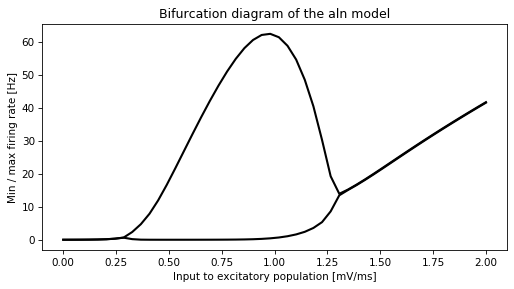

In [12]:
#hide_input
plt.figure(figsize=(8, 4), dpi=75)
plt.plot(inputs, max_outputs, c='k', lw = 2)
plt.plot(inputs, min_outputs, c='k', lw = 2)
plt.title("Bifurcation diagram of the aln model")
plt.xlabel("Input to excitatory population [mV/ms]")
plt.ylabel("Min / max firing rate [Hz]")

We can see that at low input values (between `0` and `0.25`), there is basically no activity with values of barely above 0 Hz. We call this the **down-state**. At a certain threshold point though, the lines diverge and an **oscillatory state** can be observed (between `0.25` and `1.25`). Here the activity oscillates between the excitatory and the inhibitory populations. Increasing the input even further leads to another bifurcation, resulting in a diagram where the lines converge again. The oscillation stops and the activity returns to a constant firing rate, now with an increased level than where we started. This is called the **up-state**.

## Whole-brain modeling

Typically, in whole-brain modeling, diffusion tensor imaging (DTI) is used to infer the structural connectivity (the connection strength) between different brain areas. In a DTI scan, the direction of the diffusion of molecules is measured across the whole brain. Using [tractography](https://en.wikipedia.org/wiki/Tractography), this information can yield the distribution of axonal fibers in the brain that connect distant brain areas, called the connectome. Together with an atlas that divides the brain into distinct areas, a matrix can be computed that encodes how many fibers go from one area to another, the so-called structural connectivity (SC) matrix. This matrix defines the coupling strengths between brain areas and acts as an adjacency matrix of the brain network. The length of the fibers determine the signal transmission delay between all brain areas. When the structural data is combined with a computational model of the neuronal activity of the cortex, we can create a dynamical model of the whole brain.

The resulting whole-brain model consists of interconnected brain areas, with each brain area having their internal neural dynamics. The neural activity is used to simulate hemodynamic [BOLD](https://en.wikipedia.org/wiki/Blood-oxygen-level-dependent_imaging) activity using the Balloon-Windkessel model, which can be compared to empirical fMRI data. The simulated BOLD activity is used to compute correlations of activity between all brain areas, the so called [resting state functional connectivity](https://en.wikipedia.org/wiki/Resting_state_fMRI#Functional), which can then be fitted to empirical fMRI resting-state data. One such example of simulated brain activity is shown in the animation below. 

<p align="center">
  <img src="https://github.com/neurolib-dev/neurolib/raw/master/resources/brain_slow_waves_small.gif">
</p>

## Setting up a brain

`neurolib` comes with example datasets for exploring its functionality. Please be aware that these datasets are not tested and should not be used for your research, only for experimentation with the software.

A dataset for whole-brain modeling can consists of the following parts:

* A structural connectivity (SC) matrix capturing the synaptic connection strengths between brain areas, often derived from [DTI tractography](https://en.wikipedia.org/wiki/Tractography) of the whole brain. The connectome is then typically parcellated in a preferred atlas (for example the AAL2 atlas) and the number of axonal fibers connecting each brain area with every other area is counted. This number serves as a indication of the synaptic coupling strengths between the areas of the brain. 
* A delay matrix which can be calculated from the average length of the axonal fibers connecting each brain area with another.
* A set of functional data that can act as a target for model optimization. [Resting-state fMRI](https://en.wikipedia.org/wiki/Resting_state_fMRI) BOLD activity offers an easy and fairly unbiased way for calibrating whole-brain models. Usually, not the BOLD timeseries itself is used to evaluate and fit the model, but the area-wise correlation matrix, called functional connectivity (FC) matrix. This matrix measures how well the activation and deactivation of brain areas is synchronized in time.

We can load a `Dataset` by passing the name of it in the constructor. In this case, we load processed data from the [Human Connectome Project](http://www.humanconnectomeproject.org/):

In [13]:
from neurolib.utils.loadData import Dataset
ds = Dataset("hcp")

The `hcp` dataset comes with data from a few subjects. The objects `ds.Cmat` and `ds.Dmat` represent the structural connectivity and the fiber length matrix averaged over all subjects of the dataset. The individual datasets can be accessed through `ds.Cmats`, `ds.Dmats`. Functional data per subject can be found in `ds.BOLDs` and `ds.FCs`. The latter contains the functional connectivity matrices (computed from the BOLD timeseries `ds.BOLDs`) per subject.

The connectivity matrix is a `numpy.array` with it's entries representing the coupling strength between all brain areas. Its dimensions are `N x N`, with `N` being the number of brain areas of the chosen atlas:

In [14]:
ds.Cmat.shape

(80, 80)

We now create the `aln` model with a structural connectivity matrix and a delay matrix. In order to achieve a good fit of the BOLD activity to the empirical data, the model has to run for quite a while. A a rule of thumb, a simulation of resting-state BOLD activity should not be shorter than 3 minutes and preferably longer than 5 minutes real time. If the empirical recordings are for example 10 minutes long, ideally, a simulation of 10 minutes would be used to compare the output of the model to the resting state recording.

In [15]:
# We load the model, but now with the structural dataset
aln = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)

# Let's run the simulation for a few minutes
aln.params['duration'] = 3*60*1000 

We did some optimization of the brain network model before by fitted it to the resting-state fMRI data of the dataset. 
The following set of parameters was found to produce interesting whole-brain dynamics that approximates the empirical functional connectivity (FC) data well. Specifically, the mean input of the excitatory and the inhibitory population are chosen to be close to the E-I limit cycle.

In [16]:
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
# We set an appropriate level of noise
aln.params['sigma_ou'] = 0.09
# And turn on adaptation with a low value of spike-triggered adaptation currents.
aln.params['b'] = 5.0

Let's have a look what the data looks like. We can access the
data of each model by calling its internal attributes.
Here, we plot the structural connectivity matrix by calling 
`aln.params['Cmat']` and fiber length matrix by calling 
`aln.params['lengthMat']`.
Of course, we can also access the dataset using the `Dataset`
object itself. For example the functional connectivity matrices 
of the BOLD timeseries in the datasets are given as list with 
`ds.FCs`.

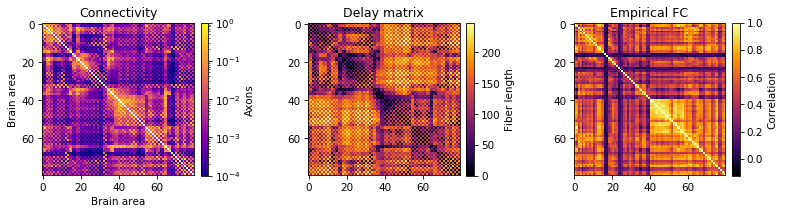

In [17]:
#hide_input
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1, 3, figsize=(12,8), dpi=75)
fig.subplots_adjust(wspace=0.6)

im = axs[0].imshow(aln.params['Cmat'], norm=LogNorm(vmin=10e-5, vmax=np.max(aln.params['Cmat'])))
axs[0].set_title("Connectivity")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04, label='Axons')
im = axs[1].imshow(aln.params['lengthMat'], cmap='inferno')
axs[1].set_title("Delay matrix")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04, label='Fiber length')
im = axs[2].imshow(ds.FCs[0], cmap='inferno')
axs[2].set_title("Empirical FC")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04, label='Correlation')

axs[0].set_xlabel("Brain area")
axs[0].set_ylabel("Brain area")
plt.show()

### Run the model

We run the model with bold simulation by using `bold=True`. 
This simulates the Balloon-Windkessel BOLD model in parallel to
the neural population model in order to estimate the blood oxygen
levels of the underlying neural activity. The output of the `bold`
model can be used to compare the simulated data to empirical fMRI 
data (resting-state fMRI for example).

To save (a lot of) RAM, we can run the simulation in `chunkwise` mode.
In this mode, the model will be simulated for a length of `chunksize` 
steps (not time in ms, but actual integration steps!), and the output
of that chunk will be used to automatically reinitialize the model with 
the appropriate initial conditions. This allows for a serial continuation
of the model without having to store all the data in memory and is 
particularly useful for very long and many parallel simulations.

In [18]:
aln.run(chunkwise=True, chunksize = 100000, bold=True)

### Analyzing simulation results

The outputs of the model can be accessed using the attribute `model.outputs`

In [19]:
aln.outputs.keys()

dict_keys(['t', 'rates_exc', 'rates_inh', 'BOLD'])

For convenience, they can also be accessed directly using attributes of the model with the outputs name, like `aln.rates_exc`. The outputs are also available as `xarray.DataArrays` as `aln.xr()`.

The since we used `bold=True` to simulate BOLD, we can also access `aln.BOLD.BOLD` for the actual BOLD activity, and `aln.BOLD.t` for the time steps of the BOLD simulation (which are downsampled to `0.5 Hz` by default).

#### Plot the simulated activity

Let's have a look at the simulated BOLD activity. We plot the simulated functional connectivity (FC) matrix that captures the correlations of the BOLD signal in each brain area, and the BOLD time series itself.

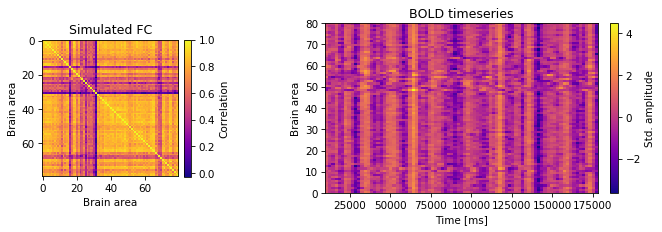

In [20]:
#hide_input
# Plot functional connectivity and BOLD timeseries (z-scored)
fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=75, gridspec_kw={'width_ratios' : [1, 2]})
fig.subplots_adjust(wspace=0.6)
im = axs[0].imshow(func.fc(aln.BOLD.BOLD[:, 5:]))
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04, label='Correlation')
im = axs[1].imshow(scipy.stats.mstats.zscore(aln.BOLD.BOLD[:, aln.BOLD.t_BOLD>10000], axis=1), aspect='auto', extent=[aln.BOLD.t_BOLD[aln.BOLD.t_BOLD>10000][0], aln.BOLD.t_BOLD[-1], 0, aln.params['N']]);
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04, label='Std. amplitude')

axs[0].set_title("Simulated FC")
axs[0].set_xlabel("Brain area")
axs[0].set_ylabel("Brain area")

axs[1].set_title("BOLD timeseries")
axs[1].set_xlabel("Time [ms]")
axs[1].set_ylabel("Brain area")
plt.show()

This looks nice! The simulated FC already looks fairly similar to the empirical FC data from our `hcp` dataset shown earlier. We have also access to the underlying neuronal activity, that caused this BOLD signal. Since we have used `model.run(chunkwise=True)` to save memory, `neurolib` didn't save the full timeseries but only the last chunk:

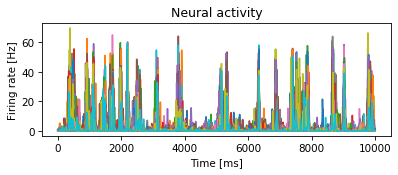

In [21]:
#Hide_input
# the results of the model are also accesible through an xarray DataArray
fig, axs = plt.subplots(1, 1, figsize=(6, 2), dpi=75)
axs.plot(aln.xr().time, aln.xr().loc['rates_exc'].T);
axs.set_title("Neural activity")
axs.set_xlabel("Time [ms]")
axs.set_ylabel("Firing rate [Hz]")
plt.show()

We can see in the timeseries above that the activity in the different brain areas (each represented by a different color) tends to synchronize and create irregular bursts of global activity resulting in slow brain oscillations.

### Correlation of simulated FC to empirical FC

We can compute the element-wise Pearson correlation of the simulated and empirical BOLD functional connectivity matrices to estimate how well the model captures the inter-areal resting-state BOLD correlations from fMRI scans. As a rule of thumb, a correlation value of `0.5` and above is considered good. We use the built-in functions `func.fc()` to calculate the functional connectivity of a n-dimensional timeseries and `func.matrix_correlation()` to compute the correlation between simulated and empirical data.

In [22]:
scores = [func.matrix_correlation(func.fc(aln.BOLD.BOLD[:, 5:]), fcemp) for fcemp in ds.FCs]

print("Correlation per subject:", [f"{s:.2}" for s in scores])
print(f"Mean FC/FC correlation: {np.mean(scores):.2}")

Correlation per subject: ['0.5', '0.56', '0.6', '0.49', '0.51', '0.48', '0.62']
Mean FC/FC correlation: 0.54


Since this notebook is automatically generated, I hope the result is pretty good :)

# Acknowledgments

`neurolib` is built on other amazing open source projects:

* [pypet](https://github.com/SmokinCaterpillar/pypet) - Python parameter exploration toolbox
* [deap](https://github.com/DEAP/deap) - Distributed Evolutionary Algorithms in Python
* [numpy](https://github.com/numpy/numpy) - The fundamental package for scientific computing with Python
* [numba](https://github.com/numba/numba) - NumPy aware dynamic Python compiler using LLVM
* [Jupyter](https://github.com/jupyter/notebook) - Jupyter Interactive Notebook
* [fastpages](https://github.com/fastai/fastpages) - An easy to use blogging platform
* [binder](https://github.com/binder-project/binder) - Reproducible executable environments
* [Bob Holzer](https://thenounproject.com/term/brain-network/100405/) is the author of the the brain network visual asset of this post's title image which is released under the Creative Commons license 

In [23]:
#hide_input
import datetime
print("Last build ", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

Last build  15.04.20 19:44:08
